<a href="https://colab.research.google.com/github/kiyong21c/Must_Have_Kaggle/blob/main/20221025_porto_driver_EarlyStopping_OOF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 조기종료 클래스 구현

class EarlyStopping:
    def __init__(self, patience=5):
        self.loss = np.inf  # 무한대값 설정
        self.patience = 0   # 초기화
        self.patience_limit = patience
        
    def step(self, loss):
        if self.loss > loss:    # 손실값이 계속 줄어드는 경우 : 무한대 값 > 손실값1 → 손실값1 > 손실값2
            self.loss = loss    # 손실값 갱신 : 무한대 값 → 손실값1 → 손실값2 → ... 계속 갱신
            self.patience = 0   # 손실값이 계속 줄어드는 경우 → 0
        else:
            self.patience += 1  # 손실값이 같거나 커지는 경우 += 1
    
    def is_stop(self):
        return self.patience >= self.patience_limit # True or False 반환

In [3]:
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/porto-seguro-safe-driver-prediction/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

In [4]:
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop('target', axis=1)

In [5]:
all_features = all_data.columns
all_features

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

In [6]:
from sklearn.preprocessing import OneHotEncoder

# 명목형 피처 추출
cat_features = [feature for feature in all_features if 'cat' in feature] 

onehot_encoder = OneHotEncoder() # 원-핫 인코더 객체 생성
# 인코딩
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features]) 

encoded_cat_matrix

<1488028x184 sparse matrix of type '<class 'numpy.float64'>'
	with 20832392 stored elements in Compressed Sparse Row format>

In [7]:
# 추가로 제거할 피처
drop_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 
                 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_14']

# '1) 명목형 피처, 2) calc 분류의 피처, 3) 추가 제거할 피처'를 제외한 피처
remaining_features = [feature for feature in all_features 
                      if ('cat' not in feature and 
                          'calc' not in feature and 
                          feature not in drop_features)]

In [8]:
from scipy import sparse

all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data[remaining_features]),
                               encoded_cat_matrix],
                              format='csr')

In [9]:
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기
X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values

In [10]:
import numpy as np

def eval_gini(y_true, y_pred):
    # 실제값과 예측값의 크기가 같은지 확인 (값이 다르면 오류 발생)
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0]                      # 데이터 개수
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # 대각선 값

    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred 크기순으로 y_true 값 정렬
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
    G_pred = np.sum(L_mid - L_pred)       # 예측 값에 대한 지니계수

    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true 크기순으로 y_true 값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true)       # 예측이 완벽할 때 지니계수

    # 정규화된 지니계수
    return G_pred / G_true

In [11]:
# LightGBM모델에 검증파라미터에 전달할 함수 정의(사용될 검증용 함수를 직접 제작)
def gini(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True # 반환값 3가지

In [12]:
from sklearn.model_selection import StratifiedKFold

# 층화 K폴드 교차 검증기
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991) # 시계열 데이터인경우 shuffle하면 안됨

In [13]:
# LightGBM의 하이퍼파라미터 설정(네가지만)
params = {'objective':'binary',     # 이진분류 문제
          'learning_rate':0.01,
          'force_row_wise':True,    # 경고 문구 제거
          'random_state':0}

In [14]:
# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_val_preds = np.zeros(X.shape[0])        # 훈련데이터(검증데이터 제회)로 훈련 → 검증데이터셋(타깃값있음)을 활용한 모델의 성능평가(정규화 지니계수이용)
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds = np.zeros(X_test.shape[0])  # 훈련데이터(검증데이터 제회)로 훈련 → 데스트데이터(타깃값없음)로 타깃값 예측

 - oof_val_preds 배열 : K폴드로 나눠도 검증데이터가 K번, 즉 모든 훈련데이터가 사용됨
  → 훈련 데이터 개수인 X.shape[0]와 같음
 - oof_test_preds 배열 : 테스트 데이터와 크기가 같음 X_test.shape[0]

In [20]:
# OOF예측(각 폴드별로 LightGBM모델 훈련)

%%time
import lightgbm as lgb

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)): # StratifiedKFold().split(X, y) : generator타입, 훈련,검증데이터셋의 인덱스 반환
    # 각 폴드를 구분하는 문구 출력
    print('#'*40, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*40)  # StratifiedKFold(n_splits=5).n_splits : 폴드 분할 개수 5

    # 훈련용 데이터, 검증용 데이터 설정
    X_train, y_train = X[train_idx], y[train_idx] 
    X_valid, y_valid = X[valid_idx], y[valid_idx] 

    # LightGBM 전용 데이터셋 생성 : lightgbm.Dataset() → 훈련 및 검증용 데이터 사용시(예측용 데이터는 원본사용)
    dtrain = lgb.Dataset(X_train, y_train) # LightGBM 전용 훈련 데이터셋
    dvalid = lgb.Dataset(X_valid, y_valid) # LightGBM 전용 검증 데이터셋

    # LightGBM 모델 훈련
    # 모델이 최고성능(=검증용 평가지표반영)을 낸 반복횟수(=조기종료 조건반영)로 예측
    lgb_model = lgb.train(params=params,             # 훈련용 하이퍼파라미터(이진분류, 학습률 등 지정)
                          train_set=dtrain,          # 전용 훈련 데이터셋
                          valid_sets=dvalid,         # 전용 검증 데이터셋, set's' 주의
                          num_boost_round=1000,      # 부스팅 반복횟수(최대반복횟수 1000회, 조기종료될 수 있음)
                          feval=gini,                # 검증용 평가지표 (자체제작)함수이름 : 3가지 값을 return해야함 → '평가지표이름', '평가점수를 return하는 함수', '평가점수가 높을수록 좋은지(True/False)'
                          early_stopping_rounds=100, # 조기종료 조건(100번연속으로 "검증용 평가지표가" 최대값을 갱신하지 못할때)
                          verbose_eval=100)          # 100번째마다 점수 출력
    
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측(예측용 데이터는 lgb.Dataset이 아닌 원본사용)
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid) # 최초 0인 초기화된 리스트에 검증데이터를 넣어서 나온 예측값으로 채움
    # oof_val_preds 최초 : [0,0,0,...][0,0,0,...][0,0,0,...][0,0,0,...][0,0,0,...] : 훈련데이터 크기와 같음(0으로 채워짐)
    # oof_val_preds 1차  : [예측값,..][0,0,0,...][0,0,0,...][0,0,0,...][0,0,0,...] 
    # oof_val_preds 2차  : [예측값,..][예측값,..][0,0,0,...][0,0,0,...][0,0,0,...] 
    
    # 테스트 데이터를 활용해 OOF 예측(예측용 데이터는 lgb.Dataset이 아닌 원본사용)
    oof_test_preds += lgb_model.predict(X_test)/folds.n_splits
    # oof_test_preds 최초 : [0,0,0,...] : 테스트데이터 크기와 같음
    # oof_test_preds 1차  : [예측값1,.] / 5
    # oof_test_preds 2차  : [예측값1,.] / 5 + [예측값2,.] / 5

    # 검증데이터 예측 확률에 대한 정규화 지니계수(검증데이터 실제값과, 검증데이터 예측값으로 지니계수확인)
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx]) # for문 속에서 '각 폴드별' 검증데이터를 이용한 지니계수확인
    print(f'폴드 {idx+1} 지니계수: {gini_score}\n')




######################################## 폴드 1 / 폴드 5 ########################################
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.15336	valid_0's gini: 0.261801
[200]	valid_0's binary_logloss: 0.152428	valid_0's gini: 0.275964
[300]	valid_0's binary_logloss: 0.152018	valid_0's gini: 0.282624
[400]	valid_0's binary_logloss: 0.151798	valid_0's gini: 0.286985
[500]	valid_0's binary_logloss: 0.151716	valid_0's gini: 0.288374
[600]	valid_0's binary_logloss: 0.151677	valid_0's gini: 0.288793
[700]	valid_0's binary_logloss: 0.151671	valid_0's gini: 0.288778
Early stopping, best iteration is:
[646]	valid_0's binary_logloss: 0.151673	valid_0's gini: 0.288887
폴드 1 지니계수: 0.2888871820172969

######################################## 폴드 2 / 폴드 5 ########################################
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.153506	valid_0's gini: 0.249477
[200]	valid_0's binary_logl

 - 모델의 성능평가 점수가 2개
 
  > valid_0's binary_logloss: 이진분류할때, LightGBM의 기본평가(default)지표 	
  
  > valid_0's gini: 모델훈련할때, feval파라미터에 전달한 gini함수의 계산 값

### 예측 및 결과 제출
 - 최종 예측 확률은 oof_test_preds에 담겨있음

In [21]:
submission['target'] = oof_test_preds
# submission.to_csv('submission.csv')

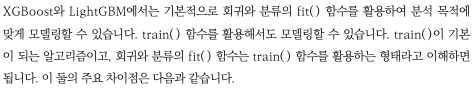

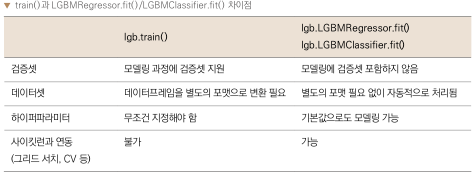

In [18]:
for train_idx, valid_idx in folds.split(X, y):
    print(train_idx, len(train_idx))
    print(valid_idx, len(valid_idx))

[     0      1      3 ... 595209 595210 595211] 476169
[     2      5     15 ... 595181 595188 595190] 119043
[     0      1      2 ... 595207 595209 595211] 476169
[     8     10     25 ... 595201 595208 595210] 119043
[     0      2      3 ... 595209 595210 595211] 476170
[     1      4      9 ... 595200 595204 595206] 119042
[     1      2      4 ... 595208 595210 595211] 476170
[     0      3      6 ... 595203 595207 595209] 119042
[     0      1      2 ... 595208 595209 595210] 476170
[    12     14     16 ... 595197 595205 595211] 119042
